#### data processing

In [3]:
import pandas as pd

DATA_PATH = "./data/data.csv"
data = pd.read_csv(DATA_PATH, names=['userid','itemid','categoryid','action','time'])

In [4]:
def convert_cat2num(df):
    # Convert categorical variable to numerical variable
    num_encode = {'action' : {'buy':2, 'pv':1}}
    df.replace(num_encode, inplace=True)
convert_cat2num(data)

In [18]:
#Not used
def check_missing_data(df):
    # check for any missing data in the df (display in descending order)
    return df.isnull().sum().sort_values(ascending=False)
miss = check_missing_data(data)
print(miss)

def convert_str_datetime(df):
    '''
    AIM -> Convert datetime(String) to datetime(format we want)
    INPUT -> df
    OUTPUT -> updated df with new datetime format
    '''
    df.insert(loc=5, column='timestamp', value=pd.to_datetime(df['time'].values, \
                                                              utc=True, unit='s').tz_convert("Asia/Shanghai").to_period("D"))
convert_str_datetime(data)

In [5]:
#remove user action once
drp_inx = data[data['userid'].isin([181445,209049,151163,16641,123015,117360,1017910,140376,161910,124587,1001148,170144
                         ,111904,151981,11921,144588,21268,155381,120134,175505,154034,212600,152435,180033,171407,206546])].index.tolist()
data.drop(data.index[drp_inx], inplace=True)

In [5]:
#unique_uid = pd.DataFrame(data.userid.drop_duplicates().sort_values())
#unique_itemid = pd.DataFrame(data.itemid.drop_duplicates().sort_values())
#unique_uid['new_userid'] = [i for i in range(0, unique_uid.shape[0])]
#unique_itemid['new_itemid'] = [i for i in range(0, unique_itemid.shape[0])]

#data = pd.merge(data, unique_uid, on='userid', how='left', left_index=True)
#data = pd.merge(data, unique_itemid, on='itemid', how='left', left_index=True)

In [6]:
data.to_csv('./data/data_1.csv', index = None, header = None)

### Model1: ItemCF

In [1]:
import pandas as pd
import random
import math
import time

In [2]:
#定义装饰器，监控运行时间
def timmer(func):
    def wrapper(*args, **kwargs): #args:tuple, kwargs:dict
        start_time = time.time()
        res = func(*args, **kwargs)
        stop_time = time.time()
        print("Func: %s, run time: %s" % (func.__name__, stop_time-start_time))
        return res
    return wrapper

In [3]:
#数据处理
class Dataset():
    def __init__(self, fp):
        self.data = self.loadData(fp)
    @timmer
    def loadData(self, fp):
        data_dict = {}
        with open(fp, 'r', encoding = 'UTF-8') as f:
            for line in f:
                ll = line.strip().split(",")
                if ll[0] not in data_dict:
                    data_dict[ll[0]] = {}
                data_dict[ll[0]][ll[1]] = ll[3]
        return data_dict

In [4]:
#评价指标，召回10中命中率
class Metric():
    def __init__(self, train, test, getRecommendation):
        self.train = train
        self.test = test
        self.getRecommendation = getRecommendation
        #self.recs = self.getRec()
    #为test中每个user推荐item
    #def getRec():
        #recs = {}
        #for user in self.test:
            #rank = self.getRecommendation(user)
            #recs[user] = rank
        #return recs
    # 定义得分函数
    def getRecallScore(self):
        score = 0
        for userid in self.test:
            rank = self.getRecommendation(userid)
            for itemid in self.test[userid]:
                items_re = []
                for item, _ in rank:
                    items_re.append(item)
                if len(items_re) == 0:
                    continue
                if itemid in items_re:
                    score += 1
                #print("Recall top50 score:", score)
        return score
    def eval(self):
        metric = {'getRecallScore': self.getRecallScore()}
        print('Metric:', metric)
        return metric

In [5]:
#算法实现
def ItemIUF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数，设置取TopK相似物品数目
    :params: N, 超参数，设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    ''' 
    # 计算物品相似度矩阵
    sim = {}
    num = {}
    for user in train:
        items = train[user]
        for i in items.keys():
            num.setdefault(i, 0)
            num[i] += 1
            sim.setdefault(i, {})
            for j in items.keys():
                if j == i: continue
                sim[i].setdefault(j, 0)
                # 相比ItemCF，主要是改进了这里
                sim[i][j] += 1 / math.log(1 + len(items))
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_item_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = train[user]
        for item,score in seen_items.items():
            for i, wi in sorted_item_sim[item][:K]:
                #if u not in seen_items:
                if i not in items:
                    items[i] = 0
                items[i] += int(score) * wi
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

In [9]:
class Experiment():
    def __init__(self, K, N, fp_train='./data/data_train.csv', fp_test='./data/data_test.csv', rt='UserCF'):
        self.K = K #topK相似物品个数
        self.N = N #topN推荐物品个数
        self.fp_train = fp_train
        self.fp_test = fp_test
        self.rt = rt
        self.alg = {'UserCF':UserCF, 'ItemIUF':ItemIUF}
        
    @timmer
    def worker(self, train, test):
        getRecommendation = self.alg[self.rt](train, self.K, self.N)
        metric = Metric(train, test, getRecommendation)
        return metric.eval()
    @timmer
    def run(self):
        metrics = {'getRecallScore': 0}
        data_train = Dataset(self.fp_train)
        data_test = Dataset(self.fp_test)
        metric = self.worker(data_train.data, data_test.data)

In [8]:
cf_exp = Experiment(200, 10, rt='ItemIUF')
cf_exp.run()

Func: loadData, run time: 2.4608285427093506
Func: loadData, run time: 0.03637385368347168
Metric: {'getRecallScore': 1756}
Func: worker, run time: 1569.8695635795593
Func: run, run time: 1572.5170917510986


In [7]:
cf_exp = Experiment(200, 100)
cf_exp.run()

Func: loadData, run time: 3.1326732635498047
Func: loadData, run time: 0.04265642166137695
Metric: {'getRecallScore': 6963}
Func: worker, run time: 1113.824132680893
Func: run, run time: 1117.1485786437988


### Model2: UserCF

In [10]:
#算法实现 基于用户余弦相似度的推荐
def UserCF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数，设置取TopK相似用户数目
    :params: N, 超参数，设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    '''
    # 计算item->user的倒排索引
    item_users = {}
    for user in train:
        for item, score in train[user].items():
            if item not in item_users:
                item_users[item] = {}
            item_users[item][user] = score
    
    # 计算用户相似度矩阵
    sim = {}
    num = {}
    for item in item_users:
        users = item_users[item]
        for u in users.keys():
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for v in users.keys():
                if v == u: continue
                if v not in sim[u]:
                    sim[u][v] = 0
                sim[u][v] += 1
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_user_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = train[user]
        for item,score in seen_items.items():
            for u, wu in sorted_user_sim[user][:K]:
                for item in train[u]:
                    # 要去掉用户见过的
                    if item not in seen_items:
                        if item not in items:
                            items[item] = 0
                        items[item] += int(score)*wu
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

In [ ]:
cf_exp = Experiment(200, 10, rt='UserCF')
cf_exp.run()

Func: loadData, run time: 2.4226391315460205
Func: loadData, run time: 0.03598308563232422


In [6]:
### Model3: LFM

In [6]:
### Model4: Personal

#### DeepMF

In [7]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import os
import heapq
import math
import sys

In [8]:
class DataSet():
    def __init__(self):
        self.data, self.shape = self.getData()
        self.train, self.test = self.getTrainTest()
        self.trainDict = self.getTrainDict()

    def getData(self):
        print("Loading data set...")
        data = []
        filePath = './data/data_1.csv'
        u = 0
        i = 0
        maxrate = 0.0
        with open(filePath, 'r') as fin:
            for line in fin:
                lines = line.strip().split(',')
                user = int(lines[5])
                item = int(lines[6])
                rate = float(lines[3])
                time = int(lines[4])
                data.append((user, item, rate, time))
                if user>u:  u = user
                if item>i:  i = item
                if rate>maxrate:  maxrate = rate
            self.maxRate = maxrate
            print("Loading Success!\n"
                  "Data Info:\n"
                  "\tUser Num: {}\n"
                  "\tItem Num: {}\n"
                  "\tData Size: {}".format(u, i, len(data)))
            return data, [u+1, i+1]

    def getTrainTest(self):
        data = self.data
        data = sorted(data, key=lambda x: (x[0], x[3]))
        train = []
        test = []
        for i in range(len(data)-1):
            user = data[i][0]
            item = data[i][1]
            rate = data[i][2]
            if data[i][0] != data[i+1][0]:
                test.append((user, item, rate))
            else:
                train.append((user, item, rate))
        test.append((data[-1][0], data[-1][1], data[-1][2]))  
        return train, test

    def getTrainDict(self):
        dataDict = {}
        for i in self.train:
            dataDict[(i[0], i[1])] = i[2]
        return dataDict

    def getEmbedding(self):
        train_matrix = np.zeros([self.shape[0], self.shape[1]], dtype=np.float32)
        for i in self.train:
            user = i[0]
            movie = i[1]
            rating = i[2]
            train_matrix[user][movie] = rating
        return np.array(train_matrix)

    def getInstances(self, data, negNum):
        user = []
        item = []
        rate = []
        for i in data:
            user.append(i[0])
            item.append(i[1])
            rate.append(i[2])
            for t in range(negNum):
                j = np.random.randint(self.shape[1])
                while (i[0], j) in self.trainDict:
                    j = np.random.randint(self.shape[1])
                user.append(i[0])
                item.append(j)
                rate.append(0.0)
        return np.array(user), np.array(item), np.array(rate)

    def getTestNeg(self, testData, negNum):
        user = []
        item = []
        for s in testData:
            tmp_user = []
            tmp_item = []
            u = s[0]
            i = s[1]
            tmp_user.append(u)
            tmp_item.append(i)
            neglist = set()
            neglist.add(i)
            for t in range(negNum):
                j = np.random.randint(self.shape[1])
                while (u, j) in self.trainDict or j in neglist:
                    j = np.random.randint(self.shape[1])
                neglist.add(j)
                tmp_user.append(u)
                tmp_item.append(j)
            user.append(tmp_user)
            item.append(tmp_item)
        return [np.array(user), np.array(item)]

In [9]:
class DeepMF():
    def __init__(self, K, negNum=4, lr=0.001, maxEpochs=20, topK=10):
        self.dataSet = DataSet()
        self.shape = self.dataSet.shape
        self.maxRate = self.dataSet.maxRate

        self.train = self.dataSet.train
        self.test = self.dataSet.test

        self.negNum = negNum
        self.testNeg = self.dataSet.getTestNeg(self.test, 99)
        self.add_embedding_matrix()

        self.add_placeholders()

        self.userLayer = [512, K]
        self.itemLayer = [512, K]
        self.add_model()

        self.add_loss()

        self.lr = lr
        self.add_train_step()

        #self.checkPoint = args.checkPoint
        self.init_sess()

        self.maxEpochs = maxEpochs
        self.batchSize = 256

        self.topK = topK
        self.earlyStop = 5


    def add_placeholders(self):
        self.user = tf.placeholder(tf.int32)
        self.item = tf.placeholder(tf.int32)
        self.rate = tf.placeholder(tf.float32)
        self.drop = tf.placeholder(tf.float32)

    def add_embedding_matrix(self):
        self.user_item_embedding = tf.convert_to_tensor(self.dataSet.getEmbedding())
        self.item_user_embedding = tf.transpose(self.user_item_embedding)

    def add_model(self):
        user_input = tf.nn.embedding_lookup(self.user_item_embedding, self.user)
        item_input = tf.nn.embedding_lookup(self.item_user_embedding, self.item)

        def init_variable(shape, name):
            return tf.Variable(tf.truncated_normal(shape=shape, dtype=tf.float32, stddev=0.01), name=name)

        with tf.name_scope("User_Layer"):
            user_W1 = init_variable([self.shape[1], self.userLayer[0]], "user_W1")
            user_out = tf.matmul(user_input, user_W1)
            for i in range(0, len(self.userLayer)-1):
                W = init_variable([self.userLayer[i], self.userLayer[i+1]], "user_W"+str(i+2))
                b = init_variable([self.userLayer[i+1]], "user_b"+str(i+2))
                user_out = tf.nn.relu(tf.add(tf.matmul(user_out, W), b))

        with tf.name_scope("Item_Layer"):
            item_W1 = init_variable([self.shape[0], self.itemLayer[0]], "item_W1")
            item_out = tf.matmul(item_input, item_W1)
            for i in range(0, len(self.itemLayer)-1):
                W = init_variable([self.itemLayer[i], self.itemLayer[i+1]], "item_W"+str(i+2))
                b = init_variable([self.itemLayer[i+1]], "item_b"+str(i+2))
                item_out = tf.nn.relu(tf.add(tf.matmul(item_out, W), b))

        norm_user_output = tf.sqrt(tf.reduce_sum(tf.square(user_out), axis=1))
        norm_item_output = tf.sqrt(tf.reduce_sum(tf.square(item_out), axis=1))
        self.y_ = tf.reduce_sum(tf.multiply(user_out, item_out), axis=1, keep_dims=False) / (norm_item_output* norm_user_output)
        self.y_ = tf.maximum(1e-6, self.y_)

    def add_loss(self):
        regRate = self.rate / self.maxRate
        losses = regRate * tf.log(self.y_) + (1 - regRate) * tf.log(1 - self.y_)
        loss = -tf.reduce_sum(losses)
        # regLoss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        # self.loss = loss + self.reg * regLoss
        self.loss = loss

    def add_train_step(self):
        '''
        global_step = tf.Variable(0, name='global_step', trainable=False)
        self.lr = tf.train.exponential_decay(self.lr, global_step,
                                             self.decay_steps, self.decay_rate, staircase=True)
        '''
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)

    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())

        self.saver = tf.train.Saver()
        if os.path.exists(self.checkPoint):
            [os.remove(f) for f in os.listdir(self.checkPoint)]
        else:
            os.mkdir(self.checkPoint)

    def run(self):
        best_hr = -1
        best_NDCG = -1
        best_epoch = -1
        print("Start Training!")
        for epoch in range(self.maxEpochs):
            print("="*20+"Epoch ", epoch, "="*20)
            self.run_epoch(self.sess)
            print('='*50)
            print("Start Evaluation!")
            hr, NDCG = self.evaluate(self.sess, self.topK)
            print("Epoch ", epoch, "HR: {}, NDCG: {}".format(hr, NDCG))
            if hr > best_hr or NDCG > best_NDCG:
                best_hr = hr
                best_NDCG = NDCG
                best_epoch = epoch
                self.saver.save(self.sess, self.checkPoint)
            if epoch - best_epoch > self.earlyStop:
                print("Normal Early stop!")
                break
            print("="*20+"Epoch ", epoch, "End"+"="*20)
        print("Best hr: {}, NDCG: {}, At Epoch {}".format(best_hr, best_NDCG, best_epoch))
        print("Training complete!")

    def run_epoch(self, sess, verbose=10):
        train_u, train_i, train_r = self.dataSet.getInstances(self.train, self.negNum)
        train_len = len(train_u)
        shuffled_idx = np.random.permutation(np.arange(train_len))
        train_u = train_u[shuffled_idx]
        train_i = train_i[shuffled_idx]
        train_r = train_r[shuffled_idx]

        num_batches = len(train_u) // self.batchSize + 1

        losses = []
        for i in range(num_batches):
            min_idx = i * self.batchSize
            max_idx = np.min([train_len, (i+1)*self.batchSize])
            train_u_batch = train_u[min_idx: max_idx]
            train_i_batch = train_i[min_idx: max_idx]
            train_r_batch = train_r[min_idx: max_idx]

            feed_dict = self.create_feed_dict(train_u_batch, train_i_batch, train_r_batch)
            _, tmp_loss = sess.run([self.train_step, self.loss], feed_dict=feed_dict)
            losses.append(tmp_loss)
            if verbose and i % verbose == 0:
                sys.stdout.write('\r{} / {} : loss = {}'.format(
                    i, num_batches, np.mean(losses[-verbose:])
                ))
                sys.stdout.flush()
        loss = np.mean(losses)
        print("\nMean loss in this epoch is: {}".format(loss))
        return loss

    def create_feed_dict(self, u, i, r=None, drop=None):
        return {self.user: u,
                self.item: i,
                self.rate: r,
                self.drop: drop}

    def evaluate(self, sess, topK):
        def getHitRatio(ranklist, targetItem):
            for item in ranklist:
                if item == targetItem:
                    return 1
            return 0
        def getNDCG(ranklist, targetItem):
            for i in range(len(ranklist)):
                item = ranklist[i]
                if item == targetItem:
                    return math.log(2) / math.log(i+2)
            return 0


        hr =[]
        NDCG = []
        testUser = self.testNeg[0]
        testItem = self.testNeg[1]
        for i in range(len(testUser)):
            target = testItem[i][0]
            feed_dict = self.create_feed_dict(testUser[i], testItem[i])
            predict = sess.run(self.y_, feed_dict=feed_dict)

            item_score_dict = {}

            for j in range(len(testItem[i])):
                item = testItem[i][j]
                item_score_dict[item] = predict[j]

            ranklist = heapq.nlargest(topK, item_score_dict, key=item_score_dict.get)

            tmp_hr = getHitRatio(ranklist, target)
            tmp_NDCG = getNDCG(ranklist, target)
            hr.append(tmp_hr)
            NDCG.append(tmp_NDCG)
        return np.mean(hr), np.mean(NDCG)

In [10]:
dmf = DeepMF(8, negNum=4, lr=0.001, maxEpochs=2, topK=10)
dmf.run()

## item2vec

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

DATA_PATH = "./data/data_1.csv"
data = pd.read_csv(DATA_PATH, names=['userid','itemid','categoryid','action','time'])

In [2]:
data['itemid']= data['itemid'].astype(str)
#data.head()

In [3]:
test_data = data.sort_values(by = 'time', ascending = False).groupby('userid').head(1)
train_data = data.drop(test_data.index.values)

In [50]:
test_data.to_csv('./data/data_test.csv', index = None, header = None)
train_data.to_csv('./data/data_train.csv', index = None, header = None)

In [4]:
users_train = train_data['userid'].unique().tolist()
len(users_train)

29128

In [5]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(users_train):
    temp = train_data[train_data['userid'] == i]['itemid'].tolist()
    purchases_train.append(temp)

100%|██████████| 29128/29128 [01:34<00:00, 307.46it/s]


In [8]:
users_test = test_data['userid'].unique().tolist()
len(users_test)

29128

In [9]:
purchases_test = []

# populate the list with the product codes
for i in tqdm(users_test):
    temp = test_data[test_data['userid'] == i]['itemid'].tolist()
    purchases_test.append(temp)

100%|██████████| 29128/29128 [00:29<00:00, 977.62it/s] 


In [6]:
#Word2Vec(sentences, size=100,window=10,min_count=3,iter=8)
# train word2vec model
model = Word2Vec(purchases_train, window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

#model.build_vocab(purchases_train, progress_per=200)

#model.train(purchases_train, total_examples = model.corpus_count, epochs=10, report_delay=1)

In [7]:
model.save("./data/word2vec")

In [8]:
def GetRecommendation_item2vec(train, N):
    users = users_train
    rank = {}
    for user in users:
        items = {}
        for i in range(len(users)):
            try:
                datas = model.most_similar(str[], topn=50)
            except KeyError:
                #print("not in vocabulary")
                continue
            for item, score in datas:
                if item not in items:
                    items[item] = 0
                items[item] += score
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        rank[user] = recs
    #with open("data/recs_by_item2vec.dat", "wb") as file:
        #pickle.dump(rank, file)
    return rank

[('3019331', 0.981833815574646),
 ('2796616', 0.9815633893013),
 ('2802327', 0.981476366519928),
 ('2514345', 0.9814358353614807),
 ('1153356', 0.9804781675338745),
 ('1474842', 0.980103611946106),
 ('3113619', 0.9800090193748474),
 ('1653234', 0.9797073602676392),
 ('3256577', 0.9795336127281189),
 ('1891183', 0.9792851209640503),
 ('1923543', 0.979226291179657),
 ('3262282', 0.9790976047515869),
 ('4935848', 0.9790670871734619),
 ('235376', 0.9786525964736938),
 ('4973108', 0.9786466360092163),
 ('3334018', 0.9785017967224121),
 ('178867', 0.9784917831420898),
 ('3833996', 0.9784207344055176),
 ('2416789', 0.9777683615684509),
 ('3124086', 0.9773887395858765),
 ('895379', 0.9773781299591064),
 ('2045425', 0.9771542549133301),
 ('5129071', 0.9770998954772949),
 ('1229600', 0.976943850517273),
 ('530211', 0.9767295122146606),
 ('1351124', 0.9766988158226013),
 ('1797604', 0.976693332195282),
 ('414682', 0.9765982031822205),
 ('971485', 0.9765753746032715),
 ('3321595', 0.97653430700302

In [8]:
#model.init_sims(replace=True)

In [9]:
print(model)

Word2Vec(vocab=129745, size=100, alpha=0.03)


In [10]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(129745, 100)

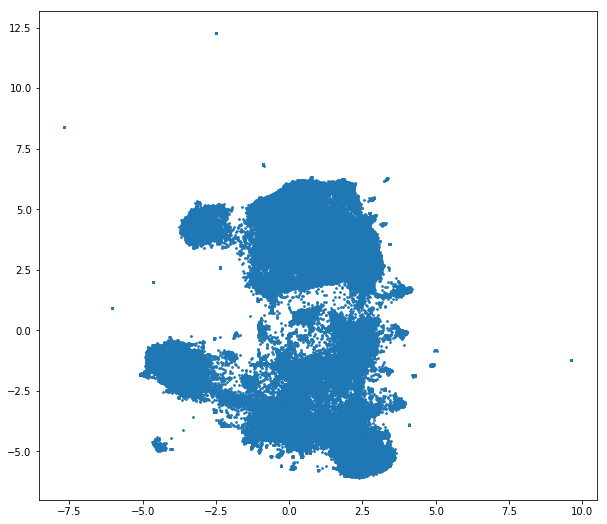

In [17]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [11]:
model.similar_by_vector(model['1603476'], topn= 10+1)[1:]

[('10598', 0.8425772190093994),
 ('2985310', 0.8278436660766602),
 ('3113619', 0.7931967973709106),
 ('4572660', 0.7908344268798828),
 ('3408873', 0.7906934022903442),
 ('3562377', 0.7800114154815674),
 ('3056379', 0.7783048152923584),
 ('986802', 0.7752604484558105),
 ('2428193', 0.7600882649421692),
 ('3112661', 0.7589476108551025)]

In [12]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [65]:
if(np.isnan(aggregate_vectors(purchases_train[0]))):
    print('hello')
#purchases_train[542]
#if(aggregate_vectors(purchases_train[542]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
model.similar_by_vector(aggregate_vectors(purchases_train[0]), topn= 50+1)[1:]

In [25]:
def GetRecommendation_item2vec(train, N):
    users = train
    rank = {}
    for i in range(len(users)):
        items = []
        datas = model.similar_by_vector(aggregate_vectors(purchases_train[0]), topn= N+1)[1:]
        for item, _ in datas:
            items.append(item)
        rank[users[i]] = items
    #with open("data/recs_by_item2vec.dat", "wb") as file:
        #pickle.dump(rank, file)
    return rank

In [26]:
rank = GetRecommendation_item2vec(users_train, 50)

KeyboardInterrupt: 

In [64]:
aggregate_vectors(purchases_train[0])

array([-0.10588353, -0.02090195,  0.04432342, -0.08812929,  0.09846103,
        0.01586407,  0.00065934,  0.09414265, -0.01379552, -0.18139148,
        0.08655261,  0.09368819, -0.01873361,  0.0765787 , -0.01471061,
       -0.1066768 ,  0.06749444,  0.14980106, -0.05233933,  0.09242366,
        0.01132055,  0.10017132, -0.00621532, -0.05970022, -0.03485535,
       -0.13682382,  0.03958335, -0.07850729,  0.02416766, -0.20515124,
        0.07703996, -0.02452032,  0.16817416, -0.07682551, -0.04606507,
       -0.13955589,  0.05124832, -0.05488637,  0.06995229, -0.00795745,
       -0.1319847 , -0.06472798,  0.03010172, -0.07125138,  0.05950009,
        0.04015524,  0.11792221,  0.07335474,  0.06803253,  0.04509572,
        0.07145496,  0.01235565,  0.05850011,  0.10551564,  0.09485536,
        0.00983007,  0.01164397, -0.13156001, -0.00434859, -0.06785244,
       -0.00536603, -0.02279287,  0.01686336,  0.08544072, -0.15567672,
       -0.04422118, -0.10497181,  0.19531953, -0.18455797, -0.03

In [63]:
for i in range(len(users_train)):
    if(np.isnan(aggregate_vectors(purchases_train[i]))):
        continue
    else:
        datas = model.similar_by_vector(aggregate_vectors(purchases_train[i]), topn= 6+1)[1:]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
class Dataset():
    def __init__(self):
        self.data = './data/data_1.csv'
        self.loadData()

    def loadData(self):
        data = {}
        for l in open(self.data):
            line = l.strip().split(',')
            if line[0] not in data:
                data[line[0]] = set()
            data[line[0]].add((line[1], int(line[4])))
        self.data = {k: list(sorted(list(data[k]), key=lambda x: x[1], reverse=True)) for k in data}
        return data

    def splitData(self):
        '''
        :params: data, 加载的所有(user, item)数据条目
        :return: train, test
        '''
        train, test = {}, {}
        for user in self.data:
            if user not in train:
                train[user] = []
                test[user] = []
            data = self.data[user]
            train[user].extend(data[1:])
            test[user].append(data[0])
        return train, test

In [3]:
train_data, test_data = Dataset().splitData()
print(train_data)
sentences = []
for user in train_data:
    data = []
    items = sorted(train_data[user], key=lambda x: (x[1]))
    for item in items:
        data.append(item[0])
    sentences.append(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [57]:
model = Word2Vec(sentences, size=100,window=10,min_count=3,iter=8)

In [58]:
model.save('./data/item2vec')

In [4]:
# 时间戳i2i召回推荐
def GetRecommendation_item2vec(train, N):
    users = train.keys()
    rank = {}
    for user in users:
        items = {}
        for i in list(dict(train[user]).keys()):
            try:
                datas = model.most_similar(i, topn=200)
            except KeyError:
                #print("not in vocabulary")
                continue
            for item, score in datas:
                if item not in items:
                    items[item] = 0
                items[item] += score
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        rank[user] = recs
    #with open("data/recs_by_item2vec.dat", "wb") as file:
        #pickle.dump(rank, file)
    return rank

In [5]:
model = Word2Vec.load('./data/item2vec')

In [ ]:
rank = GetRecommendation_item2vec(train_data, 10)